In [5]:
# Settings

# import packages
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn import metrics

# define path
my_path = "/Users/meikeepauline/Desktop/MA/"

# define variables
target_variable = ['DEFAULT_12M']
model_variables = ['fico','mi_pct','cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','channel','prop_type','loan_purpose','orig_loan_term','cd_ppty_val_type','us_reg','flag_fthb','cnt_borr','flag_mi','orig_loan_term_3grp','flag_orig_loan_term_HEQ_360M']
model_variables_ind = ['fico','mi_pct','cnt_units','cltv','dti','orig_upb','ltv','orig_loan_term','flag_fthb','cnt_borr','flag_mi','flag_orig_loan_term_HEQ_360M'\
                    ,'loan_purpose__C','loan_purpose__N','loan_purpose__P','channel__9','channel__B','channel__C','channel__R','channel__T','cd_ppty_val_type__1','cd_ppty_val_type__2','cd_ppty_val_type__3','cd_ppty_val_type__9','us_reg__Midwest','us_reg__Northeast','us_reg__Other','us_reg__South','us_reg__West','occpy_sts__I','occpy_sts__P']
all_variables = model_variables+target_variable

Import dataset and print overview

In [6]:
df_csv = pd.read_csv(my_path+"DEV_SAMPLE5Y_FINAL.CSV", parse_dates=[3], dayfirst=True, dtype={'GROUP2': 'str', 'zipcode': 'str', 'cd_ppty_val_type': 'str', 'cd_zero_bal': 'str', 'flag_sc_raw': 'str', 'id_loan_preharp': 'str','ind_harp_raw': 'str', 'zero_bal_delq_sts': 'str'})

print(df_csv.head())          # print first 5 rows
print(df_csv.info())          # print information of data (null, type)

   Selected  DEFAULT_12M GROUP2      DATUM       id_loan  loan_age_noMod  \
0         1            0   2017 2017-12-01  F17Q40279565              63   
1         1            0   2017 2017-12-01  F17Q40215556              63   
2         1            0   2017 2017-12-01  F17Q40319954              34   
3         1            0   2017 2017-12-01  F17Q40189974              63   
4         1            0   2017 2017-12-01  F17Q40162839              63   

               KEEP_FLAG  fico  dt_first_pi flag_fthb_raw  ...  \
0  1;More than 12 months   681       201712             N  ...   
1  1;More than 12 months   716       201712             N  ...   
2  1;More than 12 months   778       201712             N  ...   
3  1;More than 12 months   797       201712             N  ...   
4  1;More than 12 months   717       201712             Y  ...   

   us_reg__Midwest  us_reg__Northeast  us_reg__Other  us_reg__South  \
0                0                  0              0              0   
1   

Split data into Training and Test data set for model variables and target 

In [7]:
temp = df_csv[(df_csv.Selected == 1)]
X_train = temp[model_variables_ind]
y_train = temp[target_variable]

temp = df_csv[(df_csv.Selected == 0)]
X_test = temp[model_variables_ind]
y_test = temp[target_variable]

inp_data = df_csv[model_variables_ind]
out_data = df_csv[target_variable]

df = df_csv[target_variable+model_variables_ind]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print("DR of training sample: ", X_train["DEFAULT_12M"].mean())
#print("DR of test sample: ", X_test["DEFAULT_12M"].mean())

(7650336, 31) (3278709, 31) (7650336, 1) (3278709, 1)


Set hyperparameters

In [8]:
params = {
    "objective": "multiclass",
    "num_class": 2,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

Create LightGBM data structure

In [9]:
lgb_train = lgb.Dataset(X_train, y_train)

In [10]:
# Fit model
num_round = 10
bst = lgb.train(params, lgb_train, num_round)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.551190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 909
[LightGBM] [Info] Number of data points in the train set: 7650336, number of used features: 29
[LightGBM] [Info] Start training from score -0.009650
[LightGBM] [Info] Start training from score -4.645669


In [11]:
# Make predictions
predictions = bst.predict(X_test)
print(predictions)

[[0.97913472 0.02086528]
 [0.99385787 0.00614213]
 [0.99508188 0.00491812]
 ...
 [0.99449864 0.00550136]
 [0.98797593 0.01202407]
 [0.98878778 0.01121222]]


Create Model, Set of hyper parameters

In [6]:
RF = RFC(n_estimators=100)

Fitting the model

In [7]:
RF.fit(X_train,y_train)

In [31]:
def result(clf, PD_threshold):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)

    y_pred_Def = y_pred[:, 1]
    y_pred = np.where(y_pred_Def > PD_threshold, 1, 0)
    
    print('Accuracy Score                           : {:.4f}'.format(accuracy_score(y_test, y_pred)))
    print('LightGBM f1-score                        : {:.4f}'.format(f1_score( y_test , y_pred)))
    print('LightGBM precision                       : {:.4f}'.format(precision_score(y_test, y_pred)))
    print('LightGBM recall                          : {:.4f}'.format(recall_score(y_test, y_pred)))
    print("LightGBM roc auc score (Default flag)    : {:.4f}".format(roc_auc_score(y_test,y_pred)))
    print("LightGBM roc auc score (PD)              : {:.4f}".format(roc_auc_score(y_test,y_pred_Def)))
    print("LightGBM GINI (Default flag)             : {:.4f}".format(2*roc_auc_score(y_test,y_pred)-1))
    print("LightGBM GINI (PD)                       : {:.4f}".format(2*roc_auc_score(y_test,y_pred_Def)-1))
    print("\n",classification_report(y_pred, y_test))
    
    plt.figure(figsize=(6,6))
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap((cf_matrix / np.sum(cf_matrix)*100), annot = True, fmt=".2f", cmap="Blues")
    plt.title("LightGBM Confusion Matrix (Rate)")
    plt.show()
    
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, cmap="Blues",
                xticklabels=["FALSE","TRUE"],
                yticklabels=["FALSE","TRUE"],
                cbar=False)
    plt.title("LightGBM Confusion Matrix (Number)")
    plt.show()
    
    
def report(**params):
    scores = [] 
    for i in range(0,num_simulations): # 250 samples
        print('--- Step: ', i, '\n')
        X_train, X_test, y_train, y_test = train_test_split(inp_data, out_data, test_size=0.2, shuffle=True)
        sc = StandardScaler()
        clf = LGBMClassifier(**params)
        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)
        clf.fit(X_train, y_train)
        scores.append(accuracy_score(clf.predict(X_test), y_test)) 
        
    Importance = pd.DataFrame({'Importance':clf.feature_importances_*100},index=df.columns[1:32])
    Importance.sort_values(by='Importance',axis=0,ascending=True).plot(kind='barh',color='lightblue')
    plt.xlabel('Importance for variable');
    plt.hist(scores)
    plt.show()
    print("Best Score: {}\nMean Score: {}".format(np.max(scores), np.mean(scores)))

Accuracy Score                           : 0.9900
LightGBM f1-score                        : 0.0094
LightGBM precision                       : 0.0994
LightGBM recall                          : 0.0049
LightGBM roc auc score (Default flag)    : 0.5022
LightGBM roc auc score (PD)              : 0.7604
LightGBM GINI (Default flag)             : 0.0045
LightGBM GINI (PD)                       : 0.5208

               precision    recall  f1-score   support

           0       1.00      0.99      0.99   3277149
           1       0.00      0.10      0.01      1560

    accuracy                           0.99   3278709
   macro avg       0.50      0.54      0.50   3278709
weighted avg       1.00      0.99      0.99   3278709



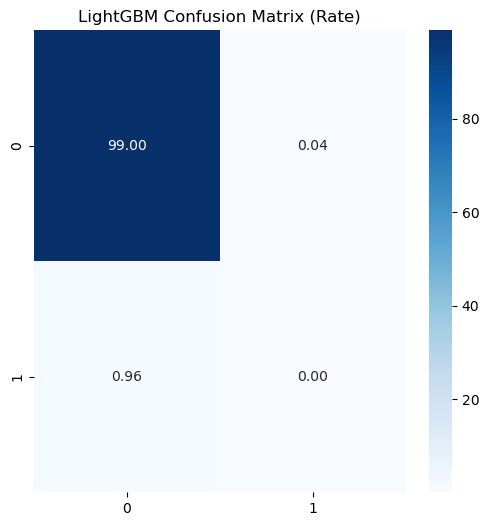

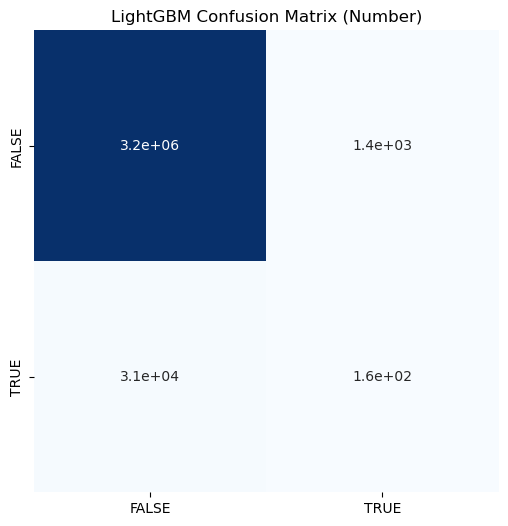

Threshold: 0.0 F1-score: 0.019021258894124236
Threshold: 0.005 F1-score: 0.02962540467174718
Threshold: 0.01 F1-score: 0.04074365064863877
Threshold: 0.015 F1-score: 0.050857077988420936
Threshold: 0.02 F1-score: 0.059035195957459305
Threshold: 0.025 F1-score: 0.06579003482834601
Threshold: 0.03 F1-score: 0.07076875065016125
Threshold: 0.035 F1-score: 0.0733817109057082
Threshold: 0.04 F1-score: 0.07296690799427312
Threshold: 0.045 F1-score: 0.07078660621967708
Threshold: 0.05 F1-score: 0.06361599789154643
Threshold: 0.055 F1-score: 0.055252268179433885
Threshold: 0.06 F1-score: 0.04733284899720406
Threshold: 0.065 F1-score: 0.03956107421311002
Threshold: 0.07 F1-score: 0.03348053815343535
Threshold: 0.075 F1-score: 0.027532593732286018
Threshold: 0.08 F1-score: 0.021885757465506143
Threshold: 0.085 F1-score: 0.01949820788530466
Threshold: 0.09 F1-score: 0.015853979582882382
Threshold: 0.095 F1-score: 0.013530755763923917


In [21]:
clf = LGBMClassifier()
result(clf, 0.5)

for threshold in np.arange(0.0, 0.1, 0.005): 
    y_pred_f1 = np.where(y_pred_Def > threshold, 1, 0)
    f1 = f1_score(y_test, y_pred_f1)
    print('Threshold:', threshold, 'F1-score:', f1)

#report()

Accuracy Score                           : 0.9619
LightGBM f1-score                        : 0.0734
LightGBM precision                       : 0.0479
LightGBM recall                          : 0.1572
LightGBM roc auc score (Default flag)    : 0.5635
LightGBM roc auc score (PD)              : 0.7604
LightGBM GINI (Default flag)             : 0.1269
LightGBM GINI (PD)                       : 0.5208

               precision    recall  f1-score   support

           0       0.97      0.99      0.98   3175280
           1       0.16      0.05      0.07    103429

    accuracy                           0.96   3278709
   macro avg       0.56      0.52      0.53   3278709
weighted avg       0.94      0.96      0.95   3278709



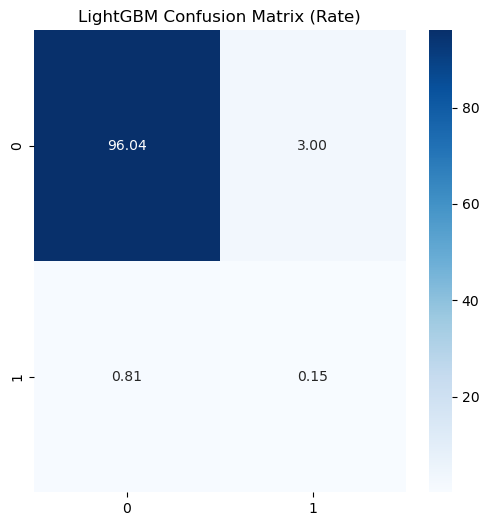

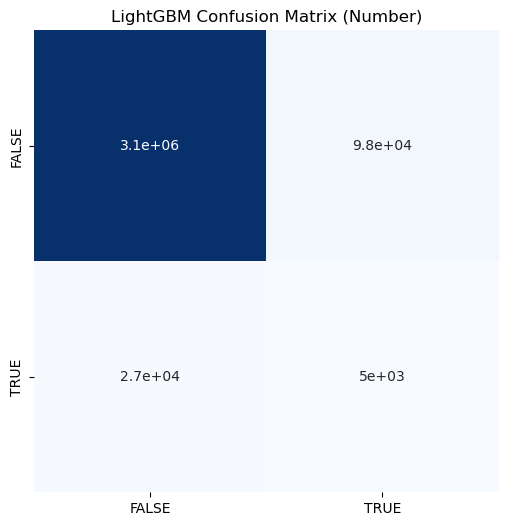

--- Step:  0 

--- Step:  1 

--- Step:  2 

--- Step:  3 



KeyboardInterrupt: 

In [33]:
result(clf, 0.035)

num_simulations = 5
report()

In [34]:
param_grid = {
    'min_child_weight': np.arange(1,20,1),
    'colsample_bytree': np.linspace(0.5,2,11)
}

clf = LGBMClassifier()
grid = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=2, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

Fitting 10 folds for each of 209 candidates, totalling 2090 fits


/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/prepr

[CV] END ...........colsample_bytree=0.5, min_child_weight=1; total time= 3.4min
[CV] END ...........colsample_bytree=0.5, min_child_weight=1; total time= 3.4min
[CV] END ...........colsample_bytree=0.5, min_child_weight=1; total time= 3.5min
[CV] END ...........colsample_bytree=0.5, min_child_weight=1; total time= 3.5min


/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/meikeepauline/anaconda3/envs/snakes/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataC

KeyboardInterrupt: 

In [ ]:
clf = LGBMClassifier(
    min_child_weight= 0.6,
    colsample_bytree= 0.65,
    n_jobs=-1
)

result(clf)

In [ ]:
report(
    max_depth= 1,
    min_child_weight= 1,
)

In [ ]:
param_grid = {
    "n_estimators": [10,100,1000,10000 ]
}

clf = LGBMClassifier()
grid = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=2, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

In [ ]:
clf = LGBMClassifier(
    max_depth= 1,
    min_child_weight= 1,
    gamma = 0.0,
    colsample_bytree= 0.5,
    n_estimators=10
)

result(clf)

In [ ]:
report(
    max_depth= 1,
    min_child_weight= 1,
    gamma = 0.0,
    colsample_bytree= 0.5,
    n_estimators=10
)

In [ ]:
param_grid = {
 'reg_alpha': [0.001, 0.005, 0.01, 0.05]
}

clf = LGBMClassifier()
grid = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=2, cv=10)
grid.fit(X_train, y_train)
grid.best_params_

In [ ]:
clf = LGBMClassifier(
    max_depth= 1,
    min_child_weight= 1,
    gamma = 0.0,
    colsample_bytree= 0.5,
    n_estimators=10,
    reg_alpha=0.001
)

result(clf)

In [ ]:
report(
    max_depth= 1,
    min_child_weight= 1,
    colsample_bytree= 0.5,
    n_estimators=10,
    reg_alpha=0.001
)

In [ ]:
clf = LGBMClassifier(
    max_depth= 1,
    n_estimators=100,
    colsample_bytree=0.9,
    gamma=0.5,
    learning_rate=0.01,
    
)

result(clf)

In [ ]:
report(
    max_depth= 1,
    n_estimators=100,
    colsample_bytree=0.9,
    gamma=0.5,
    learning_rate=0.01,
)